In [2]:
%matplotlib inline

Reproduce Natural Image Experiments using DQN
=====================================

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import matplotlib.pyplot as plt

from distributions import Categorical, DiagGaussian
from collections import namedtuple

import img_env 

import utils

import model

from PIL import Image

from random import randint
import numpy as np


Build the model
-------------
I keep almost the same architecture as the original code (model.py), except:
* I expose Q values (=dist.logits) and classification probability (=clf.logits) to ease the computation of Q values and losses in optimization steps.

In [5]:
def smoothing_average(x, factor=10):
    running_x = 0
    for i in range(len(x)):
        U = 1. / min(i+1, factor)
        running_x = running_x * (1 - U) + x[i] * U
        x[i] = running_x
    return x




class myNet(nn.Module):
	def __init__(self, obs_shape, action_space, recurrent_policy=False, dataset=None, resnet=False, pretrained=False):
		super(myNet, self).__init__()
		self.dataset = dataset
		if len(obs_shape) == 3: #our mnist case
			self.base = model.CNNBase(obs_shape[0], recurrent_policy, dataset=dataset)
		elif len(obs_shape) == 1:
			assert not recurrent_policy, \
				"Recurrent policy is not implemented for the MLP controller"
			self.base = MLPBase(obs_shape[0])
		else:
			raise NotImplementedError

		if action_space.__class__.__name__ == "Discrete": # our case
			num_outputs = action_space.n
			self.dist = Categorical(self.base.output_size, num_outputs)
		elif action_space.__class__.__name__ == "Box":
			num_outputs = action_space.shape[0]
			self.dist = DiagGaussian(self.base.output_size, num_outputs)
		else:
			raise NotImplementedError

		if dataset in ['mnist', 'cifar10']:
			self.clf = Categorical(self.base.output_size, 2)#10)

		self.state_size = self.base.state_size

	def forward(self, inputs, states, masks):
		raise NotImplementedError

	def act(self, inputs, states, masks, deterministic=False):
		value, actor_features, states = self.base(inputs, states, masks)
		self.actor_features = actor_features
		dist = self.dist(actor_features)
		Q_values = dist.logits
		if deterministic:
			action = dist.mode()
		else:
			action = dist.sample()

		action_log_probs = dist.log_probs(action)
		if self.dataset in img_env.IMG_ENVS:
			clf = self.clf(self.actor_features)
			clf_proba = clf.logits
			if deterministic:
				classif = clf.mode()
			else:
				classif = clf.sample()
			action = torch.cat([action, classif], 1)
			action_log_probs += clf.log_probs(classif)

		return value, action, Q_values, clf_proba, action_log_probs, states #dist.logits = Q values



Replay Memory
-------------
The code of ReplayMemory is essentially from the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

In [11]:
class ReplayMemory(object):

	def __init__(self, capacity):
		self.capacity = capacity
		self.memory = []
		self.position = 0

	def push(self, *args):
		"""Saves a transition."""
		if len(self.memory) < self.capacity:
			self.memory.append(None)
		self.memory[self.position] = Transition(*args)
		self.position = (self.position + 1) % self.capacity

	def sample(self, batch_size):
		return random.sample(self.memory, batch_size)

	def __len__(self):
		return len(self.memory)

Transition = namedtuple('Transition',
						('state', 'action', 'next_state', 'reward', 'curr_label'))


Optimization
-------------
The code of optimization is inspired by the [DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).             

We combine the 2 losses (classification and navigation) to the total loss and optimize the total loss.

In [25]:
def optimize_myNet(net, curr_label, BATCH_SIZE=128, optimize_clf=False):
	if len(memory) < BATCH_SIZE:
		return
	transitions = memory.sample(BATCH_SIZE)
	batch = Transition(*zip(*transitions))


	non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
										  batch.next_state)), dtype=torch.uint8).to(device)

	non_final_next_states = torch.stack([s for s in batch.next_state \
		if s is not None])
	# print ('non_final_next_states', non_final_next_states.shape)
	state_batch = torch.stack(batch.state)
	# print ('state_batch.size', state_batch.size)
	action_batch = torch.stack(batch.action)
	reward_batch = torch.cat(batch.reward)


	_, _, Q_values_batch, clf_proba_batch, _, _ = net.act(
		inputs=state_batch.float(),
		states=state_batch, masks=state_batch[1])

	state_action_values = Q_values_batch.gather(1, action_batch[:, 0].view(BATCH_SIZE,1))
	next_state_values = torch.zeros(BATCH_SIZE).to(device)

	_, _, next_Q_values_batch, _, _, _= net.act(inputs=non_final_next_states.float(),states=non_final_next_states, masks=non_final_next_states[1])

	next_state_values[non_final_mask] = next_Q_values_batch.max(1)[0].detach()

	expected_state_action_values = (next_state_values * GAMMA) + reward_batch # Compute the expected Q values
	loss_dist = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

	curr_label_batch = torch.cat(batch.curr_label)
	loss_clf = F.nll_loss(clf_proba_batch, curr_label_batch)

	total_loss = loss_dist + loss_clf
# 	optimizer_dist = optim.RMSprop(net.parameters())
# 	optimizer_dist.zero_grad()
# 	total_loss.backward()
# 	for param in net.dist.parameters():
# 		param.grad.data.clamp_(-1, 1)
# 	optimizer_dist.step()
	optimizer_clf = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
	optimizer_clf.zero_grad()
	loss_clf.backward()
	for param in net.clf.parameters():
		param.grad.data.clamp_(-1, 1)
	optimizer_clf.step()

	return total_loss, loss_clf, loss_dist


Training ....
-------------


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


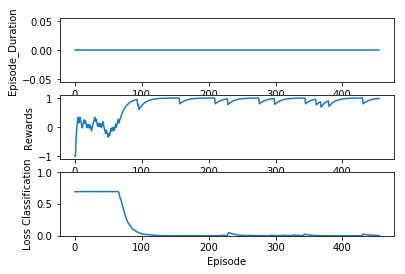

In [38]:
if __name__ == '__main__':
	BATCH_SIZE = 128
	NUM_STEPS = 1
	GAMMA = 1 - (1 / NUM_STEPS) # Set to horizon of max episode length
	EPS = 0.05
	NUM_LABELS = 2
	WINDOW_SIZE = 28
	NUM_EPISODES = 1000

	env = img_env.ImgEnv('mnist', train=True, max_steps=NUM_STEPS, channels=2, window=WINDOW_SIZE, num_labels=NUM_LABELS)
	
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

	net = myNet(\
		obs_shape=env.observation_space.shape, \
		action_space=env.action_space, dataset='mnist').to(device)
	memory = ReplayMemory(10000)
    
	total_rewards = {}
	episode_durations = {}
	loss_classification = {}
    

	for i_episode in range(NUM_EPISODES):
		total_reward_i = 0
		observation = env.reset()
		curr_label = env.curr_label.item()
		for t in range(NUM_STEPS): # allow 100 steps
			value, actionS, Q_values, clf_proba, action_log_probs, states = net.act(inputs=torch.from_numpy(observation).float().resize_(1, 2, 32, 32), \
				states=observation, masks=observation[1])
			actionS = actionS.cpu().numpy()[0]
			class_pred = actionS[1]
			last_observation = observation
			rand = np.random.rand()
			if rand < EPS:
				actionS = np.array(
					[np.random.choice(range(4)), np.random.choice(range(NUM_LABELS))])
			action = actionS[0]
			observation, reward, done, info = env.step(actionS)
			total_reward_i = reward + GAMMA*total_reward_i
			memory.push(torch.from_numpy(last_observation), torch.from_numpy(actionS), \
				torch.from_numpy(observation), torch.tensor([reward]).float(), torch.tensor([curr_label]))
# 			print ('t = %i: action = %i, class = %i, class_pred = %i, reward = %f'%(t, action, curr_label, class_pred, reward))
			optimize_myNet(net, curr_label, BATCH_SIZE)

			if done:
# 				# print ('Done after %i steps'%(t+1))
				break
		loss_classification_i = F.nll_loss(clf_proba, env.curr_label.unsqueeze_(dim=0))
		if curr_label in total_rewards.keys():
			total_rewards[curr_label].append(total_reward_i)
			episode_durations[curr_label].append(t)
			loss_classification[curr_label].append(loss_classification_i)
		else:
			total_rewards[curr_label] = [total_reward_i]
			episode_durations[curr_label] = [t]
			loss_classification[curr_label] = [loss_classification_i]
	plt.title('Class 0')
	plt.subplot(3, 1, 1)
	plt.xlabel('Episode')
	plt.ylabel('Episode_Duration')
	durations_t = torch.tensor(episode_durations[0], dtype=torch.float)
	plt.plot(smoothing_average(durations_t.numpy()))

	plt.subplot(3, 1, 2)
	plt.xlabel('Episode')
	plt.ylabel('Rewards')
	total_rewards_t = torch.tensor(total_rewards[0], dtype=torch.float)
	plt.plot(smoothing_average(total_rewards_t.numpy()))
    
	plt.subplot(3, 1, 3)
	plt.ylim(top=1)
	plt.xlabel('Episode')
	plt.ylabel('Loss Classification')
	loss_classification_t = torch.tensor(loss_classification[0], dtype=torch.float)
	plt.plot(smoothing_average(loss_classification_t.numpy()))
	plt.show()


